# Lab 8 - Neural Networks

In this lab you'll use *neural networks* to classify images using both [scikit-learn](https://scikit-learn.org) and [PyTorch](https://pytorch.org/). PyTorch 1.9 or later is assumed to be installed. The goal is for you to see:
1. that logistic regression is a special case of neural networks; and
2. how to express the same type of network in both scikit-learn and in PyTorch, both shallow (logistic regression) and deep (several layers).

**Run the code cell below** to import the required packages.

In [3]:
# !pip install torch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Digit classification with neural networks in scikit-learn

Exercise 1.1&ndash;1.8 ask you to load and train a model on the classic MNIST data set. It's so classic it has its [own Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)! The MNIST data set contains 60,000 training examples and 10,000 test examples. Each example comprises a 784-dimensional feature vector $\mathbf{x}_i$ representing 28x28 grayscale image of a hand-written digit (784 = 28x28) with a label $y_i \in \{0, \ldots, 9\}$.

Since there are 60,000 training cases, the matrix of training features $\mathbf{X}$ is provided in as a 60000x784 matrix of pixel intensities. Value $X_{i,j} \in \{0, \ldots, 255\}$ represents the intensity (0=black, 255=white) of pixel number $j$ in training image $i$. Each 784-dimensional feature vector $\mathbf{x}_i$ can be reshaped into a 28x28 image as depicted below.

![image](img/mnist_data_layout.png)

**Run the code cell below** to define a function that will be useful for plotting matrices.

In [2]:
def plot_matrix_grid(V):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    """
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

## Exercise 1.1 &ndash; Load MNIST and plot some digits

The MNIST training data has been provided to you in a file called `mnist_train.npz`. The file is located in the same directory as this Jupyter Notebook.  A `npz` file is an efficient way to store multiple Numpy arrays in a file. Use Numpy's **[load](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html)** function to open an `npz` file. When the file is opened, you can think of the file as being a Python dictionary where you can ask for an array by its name (its 'key'). The example below shows how to open the file and list the keys:

```python
>>> with np.load("mnist_train.npz") as data:
...    print(list(data.keys()))

['X', 'y']
```
(The reason we open the file using a *with*-statement is because once the *with*-statement is complete the file ("file descriptor") is automatically closed, rather than Python trying to keep the file open. This isn't important for the lab *per se*, closing files when you're done with them is just good programming practice!)


**Write a few lines of code** to load the training data from `mnist_train.npz` and create two global vaiables *X_trn* and *y_trn* to refer to the data you loaded.

In [3]:
# Your code here. Aim for 3 lines.
with np.load("mnist_train.npz") as mnist:
    X_trn = mnist['X']
    y_trn = mnist['y']



**Inspect the data** by printing information about the arrays.
1. Print the shape and dtype of both your *X_trn* and *y_trn* arrays.
2. Print the first five training samples from *X_trn* and *y_trn* arrays.

Since your *X_trn* array is big, and because most of the first/last pixels in each image are 0 (black), to see any patterns in the features try printing a slice of values taken from the "middle" of each image. For example, pixels 400:415 are roughly from the middle row of each image (similar to blue rectangle in the diagram earlier), so try printing a slice of just those pixels. You should see `[  0   0   0   0   0  81 240 253 253 119  25   0   0   0   0]` printed for the first row.

In [4]:
# Your code for printing shape and dtype here. Aim for 2 lines.
print("X shape: ", X_trn.shape[0], "\ty shape: ", y_trn[0])
print("X_train data type: ", X_trn.dtype, "\ty_train data type: ",y_trn.dtype)
# Your code for printing sample values. Aim for 2 lines.
for x,y in zip(X_trn[:5],y_trn[:5]):
    print(x,y,end='\n')

X shape:  60000 	y shape:  5
X_train data type:  uint8 	y_train data type:  int32
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0  

**Plot a few digits** to see what they look like. Use the *plot_matrix_grid* function defined earlier. To do this, you'll need to reshape the array referred to by your *X_trn* variable so that the plotting code knows the images have shape 28x28 rather than being just 784-dimensional vectors.

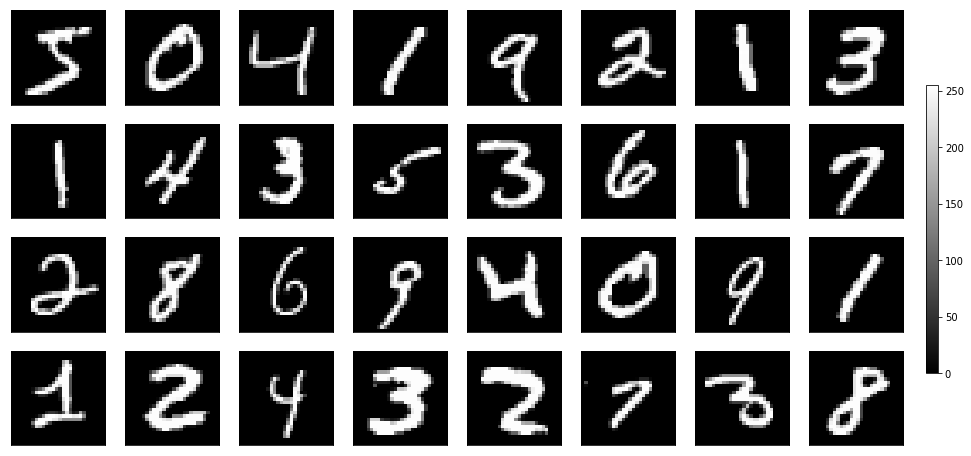

In [5]:
# Your code here. Aim for 1-2 lines.
# plot_matrix_grid()
plot_matrix_grid(np.array([i.reshape(28,28) for i in X_trn[:40]]))
# count=0
# the loop is used to plot the 8 train variables after reshaping one by one
# for index,value in enumerate(X_trn[:4]):plot_matrix_grid(np.array([X_trn[count].reshape(28,28),X_trn[count+1].reshape(28,28),X_trn[count+2].reshape(28,28),X_trn[count+3].reshape(28,28),X_trn[count+4].reshape(28,28),X_trn[count+5].reshape(28,28),X_trn[count+6].reshape(28,28),X_trn[count+7].reshape(28,28)]));count+=8

Look at the patterns you printed when inspecting the *X_trn* variable earlier, and make sure you see where they come from in the first five images plotted above.

If you want to see more of the MNIST training digits, rather than just the first few, you can try plotting different "slices" of the *X_trn* variable, such as *X_trn[100:]* to start plotting at the 101st training example. (You still have to reshape the resulting array, of course.)

Finally, **load the MNIST test data** from the file `mnist_test.npz`, just like you did for the training data. Create global variables *X_tst* and *y_tst* to refer to the arrays that you loaded. These arrays will be used to evaluate test-time accuracy later on.

In [6]:
# Your code here. Aim for 3 lines.
# loading the mnist test data and initialize the X and y values into X_tst and y_tst
with np.load("mnist_test.npz") as mnist:
    X_tst = mnist['X']
    y_tst = mnist['y']

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.2 &ndash; Preprocess the MNIST data

Certain models trained on MNIST work better when the features are normalized. Use scikit-learn to normalize the MNIST data using scaling, such as the *StandardScaler*. (You can just treat the pixels as independent features, nothing fancy.)

**Write a few lines of code** to normalize both you *X_trn* and *X_tst* variables. You can just over-write those variables with the new (normalized) feature arrays, and discard the original unscaled data.

In [7]:
# Your code here. Aim for 3-4 lines.
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_trn=scaler.fit_transform(X_trn)
X_tst=scaler.fit_transform(X_tst)

**Plot the rescaled training digits** using the *plot_matrix_grid* function. 

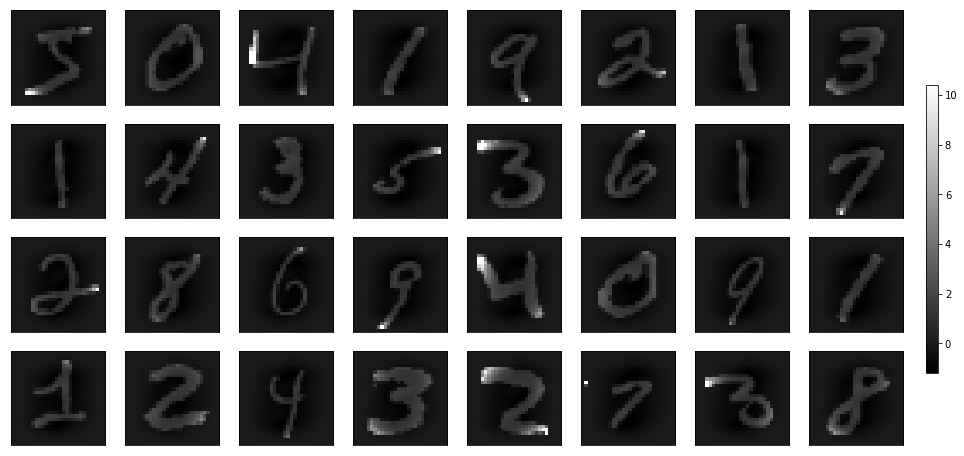

In [8]:
# Your code here. Aim for 1-2 lines.
# count=0
# for index,value in enumerate(X_trn[:4]):plot_matrix_grid(np.array([X_trn[count].reshape(28,28),X_trn[count+1].reshape(28,28),X_trn[count+2].reshape(28,28),X_trn[count+3].reshape(28,28),X_trn[count+4].reshape(28,28),X_trn[count+5].reshape(28,28),X_trn[count+6].reshape(28,28),X_trn[count+7].reshape(28,28)]));count+=8
plot_matrix_grid(np.array([i.reshape(28,28) for i in X_trn[:40]]))

Notice that the pixels in the center tend to be scaled down more than the pixels in the periphery. *Do you understand why?*

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.3 &ndash; Train multinomial logistic regression on MNIST

Train a **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** object to classify MNIST digits. Use *random_state*=0 and default settings otherwise.

In [10]:
# Your code here. Aim for 2-3 lines.
# train the model with Logistic regression 
log=sklearn.linear_model.LogisticRegression(random_state=0)
# fit the train data to a model
log.fit(X_trn,y_trn)

LogisticRegression(random_state=0)

You can use the **[score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score)** method of the *LogisticRegression* object to compute the accuracy as a number in the range $[0.0, 1.0]$. Figure out how to convert that number (e.g., 0.934) into an error rate percentage (e.g., 6.6%).

**Print the training _error rate_ and testing _error rate_** of your logistic regression model on the MNIST data set. Your output should be in the form:
```
X.XX% training error
X.XX% testing error
```

In [11]:
# Your code here. Aim for 2-4 lines.
# print the trainig error score and testing error score
print(f"{round((1-log.score(X_trn,y_trn))*100,2)}% training error")
print(f"{round((1-log.score(X_tst,y_tst))*100,2)}% testing error")

5.65% training error
7.68% testing error


How does the testing error rate you see compare to some of the error rates mentioned on the [MNIST Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)?

**Print the predicted class probabities** of the **first five examples** in the training set. Use the *predict_proba* method of your *LogisticRegression* object. The first row of output should look something like:
```
[0.001 0.    0.    0.203 0.    0.796 0.    0.    0.    0.   ]
```
From the above probabilities we can see that the model thinks the first digit in the training set is *probably* digit "5" but *might also be* digit "3".

In [12]:
# Your code here. Aim for 1-2 lines.
# using predict_proba function to print the first 5 X train values
print(log.predict_proba(X_trn[:5]))

[[0.001 0.    0.    0.203 0.    0.796 0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.002 0.001 0.013 0.949 0.    0.    0.035 0.    0.   ]
 [0.    0.991 0.006 0.    0.    0.    0.    0.    0.002 0.   ]
 [0.    0.    0.    0.    0.014 0.    0.    0.006 0.001 0.979]]


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.4 &ndash; Visualize the weights of your logistic regression model

The logisitic regression model you trained in Exercise 1.3 has a *coef_* attribute. This attribute is the array of weights $\mathbf{W}$ seen in Lecture 4 (e.g. slide 28). For the MNIST data, this matrix has shape (10, 784), because there are 10 output classes and 784=28x28 pixels. Weight $W_{k,j}$ is the weight with which of pixel $j$ contributes to output class $k$.

You are asked to visualize the weights using *plot_matrix_grid*. You may need to reshape the weight matrix to do this. The first two outputs, corresponding to predictin digit "0" and predicting digit "1" should look something like this:

<img src="img/mnist_logistic_regression_weights.png" width=180/>

Notice how the pattern for "0" is has strong negative weights in the center: that's because if there are white pixels in the center, it's unlikely that the image represents digit "0"!

<span style="color:red">If your weight patterns appear **noisier** than above, try repeating Exercise 1.3 but weaken *LogisticRegression*'s L2 penalty by a factor of 100 from its default. Take note of any change in training/test accuracy, too.</span>

**Write a few lines of code** to plot the weights and see what patterns they contain. You should see ten patterns. (Don't worry if the last few grid entries are just white boxes.)

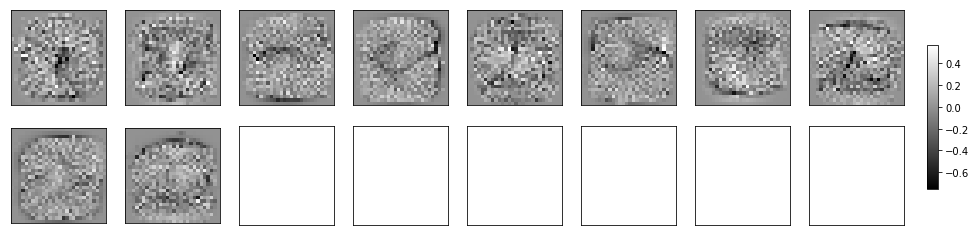

In [13]:
# Your code here. Aim for 1-2 lines.
# reshape the images data using comprehension method
co=[i.reshape(28,28) for i in log.coef_]
# passing the coeficient array values to plot function for ploting results 
plot_matrix_grid(np.array(co))


When an input image (of a hand-written digit) causes one of these patterns to have a large positive response (strong activation), then the corresponing class $\{0, 1, 2, \ldots, 9\}$ will be given a high probability by the final softmax operation.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.5 &ndash; Train a neural network on MNIST with *zero* hidden layers

Train a neural network on MNIST using the **[sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)** class.

A neural network has *many* more hyperparameters to configure. Configure your neural network as follows:
* Ask for *no hidden layers*. You can do this by specifying an empty tuple `()` for the *hidden_layer_sizes* argument. This will create a neural network where the 784 input features are directly 'connected' to the 10 output predictions, which in this case corresponds to the multinomial logistic regression you did in Exercise 1.4.
* Use the `sgd` solver. This means *stochastic gradient descent* that we saw in Lecture 1.
* Use a batch size of 100. This means that at each step of SGD the gradient will be computed from only 100 of the 60,000 training cases. This is also callsed a "mini-batch". The SGD algorithm works by starting with the firs 100, then the next 100, and then it gets to the last 100 in the training set it starts from the beginning again.
* Use *max_iter*=10. This causes the training to stop after SGD has passed over all 60,000 training cases exactly 10 times.
* Use *learning_rate_init*=0.01, which determines the step size for SGD once it has computed a gradient.
* Use *momentum*=0.9, which speeds up training.
* Use *random_state*=0 for reproducibility
* Use *verbose*=True to see progress printed out. Each time it prints "Iteration X" it means SGD has made another pass over all 60,000 training examples.

In [14]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
# train model via MLP classifier with 0 hidder layer and put the values as directed above 
NN=sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(),solver='sgd', batch_size=100, max_iter=10, learning_rate_init=0.01, momentum=0.9, random_state=0,verbose=True)

**Print the training error rate and test error rate** of your neural network classifier, just like you did for logistic regression.

In [15]:
# Your code here. Aim for 2-4 lines.
# fitting the values
NN.fit(X_trn,y_trn)
print(f"{round((1-NN.score(X_trn,y_trn))*100,2)}% training error")
print(f"{round((1-NN.score(X_tst,y_tst))*100,2)}% testing error")

Iteration 1, loss = 0.40770306
Iteration 2, loss = 0.30859873
Iteration 3, loss = 0.29337169
Iteration 4, loss = 0.28490254
Iteration 5, loss = 0.27543585
Iteration 6, loss = 0.26958339
Iteration 7, loss = 0.26545986
Iteration 8, loss = 0.26427636
Iteration 9, loss = 0.26236903
Iteration 10, loss = 0.25963997
6.84% training error
7.75% testing error


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.6 &ndash; Visualize the weights of a neural network (no hidden layers)

The *MLPClassifier* object has a *coefs_* attribute that works just like the *coef_* attribute that contained coefficient matrix $\mathbf{W}$ of *LogisticRegression*, except that for a neural network there are two differences:
1. *coefs_* is a *list* of coefficient matrices, so *coefs_[0]* is $\mathbf{W}^{(1)}$, the coefficient matrix of the *first layer*. Since the neural network you trained in Exercise 1.5 has no hidden layers, this
$\mathbf{W}^{(1)}$ matrix holds the same weights as the $\mathbf{W}$ matrix for LogisticRegression.
2. The weight matrix for *MLPClassifier* has a different layout: it is 784x10 rather than 10x784. Do you now how to account for this?

**Write a few lines of code** to repeat Exercise 1.4 but this time with the neural network weights.

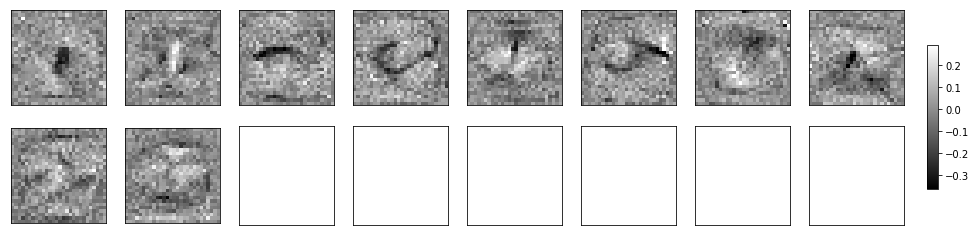

In [16]:
# Your code here. Aim for 1-2 lines.
# reshape the images and change layout from 784x10 to 10x784
co=[i.reshape(28,28) for i in NN.coefs_[0].T]
plot_matrix_grid(np.array(co))


If your patterns look streaky then you may need to try transposing your weight matrix to account for the different layout.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.7 &ndash; Train and visualize the weights of a neural network with 1 hidden layer

Here you're asked to train a neural network like you did in Exercise 1.5, but this time **add a hidden layer with 16 'tanh' hidden units** to your neural network. Then you'll visualize the weights of this network.

Read the documentation for **[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)** to learn how to do specify a hidden layer. (*Note:* In Python if you want to create a *tuple* object with only one item in it, you can use *(item,)* with an extra comma, rather than *(item)*, which Python interprets to just be regular parentheses.) All the other hyperparameters can stay the same as Exercise 1.5.

**Write a few lines of code** to train a new neural network, this time with 16 *tanh* hidden units. In other words, this will be a 784-16-10 neural network where the hidden layer uses *tanh* activations. 

In [17]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
# same method use as in 1.8 but here change the hiider layer size and add activation parameter to MLP classifier
NN=sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(16,), activation='tanh',solver='sgd', batch_size=100, max_iter=10, learning_rate_init=0.01, momentum=0.9, random_state=0,verbose=True)

**Print the training error rate and test error rate** of your neural network classifier, just like you did for logistic regression. How does your error rate compare to multinomial logistic regression? (Exercises 1.3 and 1.5)

In [18]:
# Your code here. Aim for 2-4 lines.
NN.fit(X_trn,y_trn)
print(f"{round((1-NN.score(X_trn,y_trn))*100,2)}% training error")
print(f"{round((1-NN.score(X_tst,y_tst))*100,2)}% testing error")

Iteration 1, loss = 0.47011299
Iteration 2, loss = 0.26978585
Iteration 3, loss = 0.23458535
Iteration 4, loss = 0.21459244
Iteration 5, loss = 0.19994936
Iteration 6, loss = 0.19026849
Iteration 7, loss = 0.18173445
Iteration 8, loss = 0.17397831
Iteration 9, loss = 0.16790016
Iteration 10, loss = 0.16357402
4.18% training error
6.43% testing error


**Plot the first-layer weights $\mathbf{W}^{(1)}$ of your neural network** using the *plot_matrix_grid* function, just in Exercise 1.6.

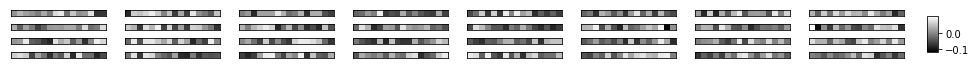

In [19]:
# Your code here. Aim for 1-2 lines.
# reshape the coeficients with weights 1
co=[[i] for i in NN.coefs_[0]]
plot_matrix_grid(np.array(co))

Notice that there are now 16 patterns, not 10, and they no longer seem to correspond to the digits $\{0,1,\ldots,9\}$ in any particular order. *Do you understand why?*

**Plot the second-layer weights $\mathbf{W}^{(2)}$ of your neural network** using the *plot_matrix_grid* function. 

However, this time if you inspect the shape of the second weight matrix, *coefs_[1]*, you'll see that it has shape $(16, 10)$, and so it cannot be reshaped into a 28x28 pattern. In fact the second layer has only dimension: the "hidden layer" is just a vector of 16 values (the 16 tanh-transformed activations of the first-layer patterns). Each of the 10 output units has 16 weights contributing to it, rather than 784 weights like in Exercise 1.6.

Figure out how to reshape the weight matrix so that when you call *plot_matrix_grid* you see a grid of 1x16 weight vectors, like the two examples below:
![image](img/mnist_mlp_hidden_weights.png)

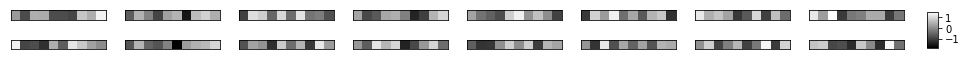

In [20]:
# Your code here. Aim for 1-2 lines.
co=[[i] for i in NN.coefs_[1]]
plot_matrix_grid(np.array(co))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.8 &ndash; Train a neural network with lots of hidden units

Repeat Exercise 1.7 but with two hidden layers having **100 and 50 hidden units** respectively. This time use **_relu_ activations**. All other hyperparameters can stay the same.

**Write a few lines of code** to train the model here.

In [22]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
# train the model and change the hiddern layer size and activation parameter to relue
NN=sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,50,), activation='relu',solver='sgd', batch_size=100, max_iter=10, learning_rate_init=0.01, momentum=0.9, random_state=0,verbose=True)

**Print the training and testing error rates** here. *How do they compare to earlier models?*

In [23]:
# Your code here. Aim for 2-4 lines.
NN.fit(X_trn,y_trn)
print(f"{round((1-NN.score(X_trn,y_trn))*100,2)}% training error")
print(f"{round((1-NN.score(X_tst,y_tst))*100,2)}% testing error")

Iteration 1, loss = 0.33306221
Iteration 2, loss = 0.13727616
Iteration 3, loss = 0.09523979
Iteration 4, loss = 0.07193538
Iteration 5, loss = 0.05528783
Iteration 6, loss = 0.04298481
Iteration 7, loss = 0.03308290
Iteration 8, loss = 0.02760081
Iteration 9, loss = 0.02298517
Iteration 10, loss = 0.01933388
0.22% training error
2.72% testing error


**Plot the first-layer weights $\mathbf{W}^{(1)}$ of your neural network** here. *Are the pattern detectors here qualitatively different than for earlier models?*

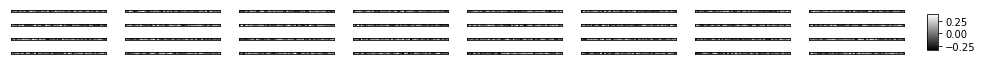

In [24]:
# Your code here. Aim for 1-2 lines.
co=[[i] for i in NN.coefs_[1]]
plot_matrix_grid(np.array(co))

Don't bother plotting the 2nd and 3rd layer weights, they are high-dimensional and hard to interpret.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Neural networks in PyTorch

Exercise 2.1&ndash;2.3 ask you to train a simple neural network in **[PyTorch](https://pytorch.org/docs/stable/index.html)**. Here you'll use PyTorch to train an MNIST classifier using the same MNIST data that you already preprocess in Part 1. The goal is just to get you familiar with PyTorch basics and how they compare to scikit-learn.

PyTorch is a deep learning framework like TensorFlow. PyTorch tends to be popular with deep learning researchers because it's very flexible for trying new ideas. TensorFlow is also flexible but is designed in such a way that it's more popular for companies trying to deploy high-performance models (in the cloud etc). Both can be used for research, of course! 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.1 &ndash; Convert MNIST from Numpy arrays to PyTorch tensors

PyTorch has its own Numpy-like array class, called *Tensor*. In order to train a PyTorch model, you must first convert the Numpy arrays. PyTorch understands Numpy arrays, so this is easy. The only tricky part is that, in order to be fast and not waste memory, PyTorch tends to be more picky about the *dtype* of the arrays you give it.

**Write a few lines of code** to create four global variables: *X_trn_torch, y_trn_torch, X_tst_torch, y_tst_torch* that are PyTorch versions of your preprocessed MNIST training data from Part 1. The *X* tensors should have *dtype* float32, and the *y* tensors should have *dtype* int64.

In [25]:
# Your code here. Aim for 2-4 lines.
# convert the numpy array to torch and assign to X_trn torch with dtype float32
X_trn_torch = torch.from_numpy(X_trn).type(torch.FloatTensor)
# convert the numpy array to torch and assign to y_trn torch with dtype int64
y_trn_torch = torch.from_numpy(y_trn).type(torch.LongTensor)

X_tst_torch = torch.from_numpy(X_tst).type(torch.FloatTensor)
y_tst_torch = torch.from_numpy(y_tst).type(torch.LongTensor)

**Run the code cell below** to check your answer.

In [26]:
assert 'X_trn_torch' in globals(), "You didn't declare a X_trn_torch variable!"
assert 'y_trn_torch' in globals(), "You didn't declare a y_trn_torch variable!"
assert 'X_tst_torch' in globals(), "You didn't declare a X_tst_torch variable!"
assert 'y_tst_torch' in globals(), "You didn't declare a y_tst_torch variable!"
assert isinstance(X_trn_torch, torch.Tensor)
assert isinstance(y_trn_torch, torch.Tensor)
assert isinstance(X_tst_torch, torch.Tensor)
assert isinstance(y_tst_torch, torch.Tensor)
assert X_trn_torch.dtype == torch.float32
assert y_trn_torch.dtype == torch.int64
assert X_trn_torch.shape == (60000,784)
assert y_trn_torch.shape == (60000,)
assert X_tst_torch.dtype == torch.float32
assert y_tst_torch.dtype == torch.int64
assert X_tst_torch.shape == (10000,784)
assert y_tst_torch.shape == (10000,)
print("Correct!")

Correct!


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.2 &ndash; Train a PyTorch neural network *without* hidden layers

This exercise only asks you to **run existing code** so that you learn how PyTorch works. The code in this cell defines a simple logistic model, and then you are asked to modify the code to add hidden layers to the network.

Useful documentation for understanding the code that you see:
* **[torch.nn](https://pytorch.org/docs/stable/nn.html)** (neural network)
* **[torch.optim](https://pytorch.org/docs/stable/optim.html)** (optimizers such as SGD)

Here are some comments to help you understand the "starter code" below:

* A neural network is a sequence of non-linear transformations, so PyTorch provides a **[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)** class that accepts a list of desired transformations.

* In a standard neural network, the transformations are just linear, i.e. $\mathbf{Wx}+\mathbf{b}$, and in PyTorch this is implemented by a **[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)** class where constructing one of these objects with *Linear(D, M)* tells the new object that it should be expecting an *D*-dimensional input and transform it into a *M*-dimensional output. To do this, the *Linear* object will create its own parameter matrix $\mathbf{W} \in \mathbb{R}^{M\times D}$ and bias vector $\mathbf{b} \in \mathbb{R}^M$.

* In PyTorch, the **[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)** class conveniently combines applying a softmax and then computing the negative log likelihood, so you don't explicitly apply softmax while training. Once you have a *CrossEntropyLoss* object, you can call it with your predictions and targets (both vectors), and it will compute the negative log likelihood, which is just one number (a scalar).
 


**Run the code cell below** to define a simple 784-10 neural network (i.e. logistic regression).

In [27]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Create an object that holds a sequence of layers and activation functions
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10),   # Applies Wx+b from 784 dimensions down to 10
)

**Run the code cell below** to define some objects and variables needed for training the neural network.

In [28]:
# Create an object that can compute "negative log likelihood of a softmax"
loss = torch.nn.CrossEntropyLoss()

# Use stochastic gradient descent to train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Use 100 training samples at a time to compute the gradient.
batch_size = 100

# Make 10 passes over the training data, each time using batch_size samples to compute gradient
num_epoch = 10
next_epoch = 1

**Run the code cell below** to train the neural network using stochastic gradient descent (SGD). *Note that if you re-run this code cell multiple times it will "continue" training from the current parameters, and if you want to "reset" the model you need to re-run the earlier code cell that defined the model!*

In [29]:
for epoch in range(next_epoch, next_epoch+num_epoch):
    
    # Make an entire pass (an 'epoch') over the training data in batch_size chunks
    for i in range(0, len(X_trn), batch_size):        
        X = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
        y = y_trn_torch[i:i+batch_size]     # Slice out a mini-batch of targets

        y_pred = model(X)                   # Make predictions (final-layer activations)
        l = loss(y_pred, y)                 # Compute loss with respect to predictions
        
        model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
        l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
        optimizer.step()                    # Use the gradients to take a step with SGD.
        
    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
    
print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
next_epoch = epoch+1

Epoch  1: loss on final training batch: 0.7097
Epoch  2: loss on final training batch: 0.8752
Epoch  3: loss on final training batch: 0.3313
Epoch  4: loss on final training batch: 0.3312
Epoch  5: loss on final training batch: 0.3239
Epoch  6: loss on final training batch: 0.3168
Epoch  7: loss on final training batch: 0.3128
Epoch  8: loss on final training batch: 0.3074
Epoch  9: loss on final training batch: 0.3044
Epoch 10: loss on final training batch: 0.2990
Epoch 10: loss on test set: 0.3182


**Run the code cell below** to retrieve the PyTorch model's parameters, convert them back to Numpy, and plot them like before.

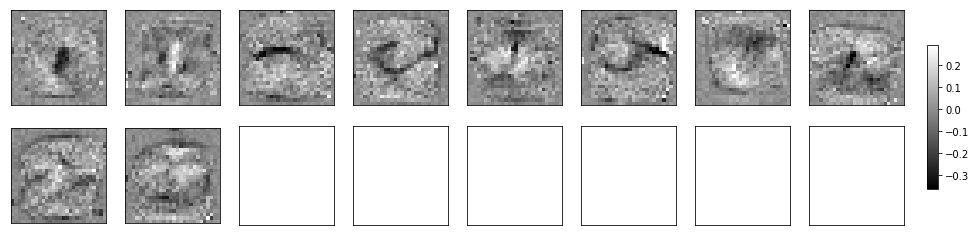

In [30]:
W, b, *_ = model.parameters()
W = W.detach().numpy()
plot_matrix_grid(W.reshape(-1, 28, 28))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.3 &ndash; Train a PyTorch neural network *with* hidden layers

Using Exercise 2.2 as a starting point, write new code to **implement a 784-100-50-10 neural network** with **_relu_ activations** just like you did in Exercise 1.8, but now implemented with PyTorch.

To do this, you will need to:
1. Create a new *model* object that has more sequential steps to it, including the *Linear* and **[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)** objects.
2. Create a new *optimizer* object that knows about your new model's parameters.

If you succeed, you should be able to get the training loss to go to zero, especially if you run the training loop code cell extra times (i.e. more than 10 epochs total). *But what happens with the test set loss, as you continue training?*

We will do more PyTorch in the next lab, with convolutional neural networks.

In [55]:
# Your PyTorch to create the model and optimizer here. 
# create a model object to assign the shapes using Torch with Linear and ReLU objects 

input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 10
batch_size = 100
learning_rate = 0.001 
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = torch.nn.Linear(input_size, hidden_size) 
        self.relu = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size, num_classes)
        self.l3 = torch.nn.Linear(num_classes, num_epochs)
        self.l4 = torch.nn.Linear(num_epochs, batch_size)
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        # no activation and no softmax at the end
        return out
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = torch.nn.CrossEntropyLoss()
# optimizer parameter 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [56]:
# Your PyTorch training loop here.
n_total_steps = len(X_trn)
for epoch in range(num_epochs):
    for i in range(0, len(X_trn), batch_size):        
        X = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
        y = y_trn_torch[i:i+batch_size] 

        images = X.reshape(-1, 28*28)
        labels = y
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/10], Step[1/60000], Loss: 4.6041
Epoch [1/10], Step[101/60000], Loss: 4.6043
Epoch [1/10], Step[201/60000], Loss: 4.6105
Epoch [1/10], Step[301/60000], Loss: 4.5667
Epoch [1/10], Step[401/60000], Loss: 4.5663
Epoch [1/10], Step[501/60000], Loss: 4.5342
Epoch [1/10], Step[601/60000], Loss: 4.5760
Epoch [1/10], Step[701/60000], Loss: 4.5264
Epoch [1/10], Step[801/60000], Loss: 4.5255
Epoch [1/10], Step[901/60000], Loss: 4.4965
Epoch [1/10], Step[1001/60000], Loss: 4.4496
Epoch [1/10], Step[1101/60000], Loss: 4.4190
Epoch [1/10], Step[1201/60000], Loss: 4.4321
Epoch [1/10], Step[1301/60000], Loss: 4.4237
Epoch [1/10], Step[1401/60000], Loss: 4.3486
Epoch [1/10], Step[1501/60000], Loss: 4.3053
Epoch [1/10], Step[1601/60000], Loss: 4.2564
Epoch [1/10], Step[1701/60000], Loss: 4.2200
Epoch [1/10], Step[1801/60000], Loss: 4.2083
Epoch [1/10], Step[1901/60000], Loss: 4.1407
Epoch [1/10], Step[2001/60000], Loss: 4.1543
Epoch [1/10], Step[2101/60000], Loss: 4.0368
Epoch [1/10], Step[220

Epoch [1/10], Step[21901/60000], Loss: 0.2868
Epoch [1/10], Step[22001/60000], Loss: 0.1590
Epoch [1/10], Step[22101/60000], Loss: 0.4308
Epoch [1/10], Step[22201/60000], Loss: 0.3979
Epoch [1/10], Step[22301/60000], Loss: 0.1566
Epoch [1/10], Step[22401/60000], Loss: 0.4934
Epoch [1/10], Step[22501/60000], Loss: 0.8327
Epoch [1/10], Step[22601/60000], Loss: 0.3898
Epoch [1/10], Step[22701/60000], Loss: 0.2677
Epoch [1/10], Step[22801/60000], Loss: 0.1880
Epoch [1/10], Step[22901/60000], Loss: 0.1596
Epoch [1/10], Step[23001/60000], Loss: 0.3279
Epoch [1/10], Step[23101/60000], Loss: 0.3876
Epoch [1/10], Step[23201/60000], Loss: 0.1948
Epoch [1/10], Step[23301/60000], Loss: 0.2003
Epoch [1/10], Step[23401/60000], Loss: 0.2931
Epoch [1/10], Step[23501/60000], Loss: 0.2582
Epoch [1/10], Step[23601/60000], Loss: 0.3191
Epoch [1/10], Step[23701/60000], Loss: 0.3440
Epoch [1/10], Step[23801/60000], Loss: 0.3406
Epoch [1/10], Step[23901/60000], Loss: 0.4240
Epoch [1/10], Step[24001/60000], L

Epoch [1/10], Step[43101/60000], Loss: 0.3023
Epoch [1/10], Step[43201/60000], Loss: 0.1660
Epoch [1/10], Step[43301/60000], Loss: 0.1011
Epoch [1/10], Step[43401/60000], Loss: 0.0919
Epoch [1/10], Step[43501/60000], Loss: 0.7080
Epoch [1/10], Step[43601/60000], Loss: 0.2383
Epoch [1/10], Step[43701/60000], Loss: 0.3226
Epoch [1/10], Step[43801/60000], Loss: 0.3952
Epoch [1/10], Step[43901/60000], Loss: 0.2943
Epoch [1/10], Step[44001/60000], Loss: 0.2206
Epoch [1/10], Step[44101/60000], Loss: 0.4027
Epoch [1/10], Step[44201/60000], Loss: 0.4152
Epoch [1/10], Step[44301/60000], Loss: 0.3212
Epoch [1/10], Step[44401/60000], Loss: 0.3640
Epoch [1/10], Step[44501/60000], Loss: 0.1366
Epoch [1/10], Step[44601/60000], Loss: 0.1080
Epoch [1/10], Step[44701/60000], Loss: 0.3004
Epoch [1/10], Step[44801/60000], Loss: 0.3847
Epoch [1/10], Step[44901/60000], Loss: 0.3360
Epoch [1/10], Step[45001/60000], Loss: 0.3487
Epoch [1/10], Step[45101/60000], Loss: 0.7467
Epoch [1/10], Step[45201/60000], L

Epoch [2/10], Step[4801/60000], Loss: 0.1329
Epoch [2/10], Step[4901/60000], Loss: 0.2284
Epoch [2/10], Step[5001/60000], Loss: 0.1578
Epoch [2/10], Step[5101/60000], Loss: 0.4219
Epoch [2/10], Step[5201/60000], Loss: 0.0841
Epoch [2/10], Step[5301/60000], Loss: 0.1915
Epoch [2/10], Step[5401/60000], Loss: 0.0895
Epoch [2/10], Step[5501/60000], Loss: 0.1562
Epoch [2/10], Step[5601/60000], Loss: 0.1926
Epoch [2/10], Step[5701/60000], Loss: 0.1651
Epoch [2/10], Step[5801/60000], Loss: 0.2808
Epoch [2/10], Step[5901/60000], Loss: 0.0742
Epoch [2/10], Step[6001/60000], Loss: 0.0838
Epoch [2/10], Step[6101/60000], Loss: 0.1403
Epoch [2/10], Step[6201/60000], Loss: 0.1830
Epoch [2/10], Step[6301/60000], Loss: 0.1574
Epoch [2/10], Step[6401/60000], Loss: 0.1402
Epoch [2/10], Step[6501/60000], Loss: 0.0724
Epoch [2/10], Step[6601/60000], Loss: 0.1738
Epoch [2/10], Step[6701/60000], Loss: 0.1281
Epoch [2/10], Step[6801/60000], Loss: 1.1325
Epoch [2/10], Step[6901/60000], Loss: 0.3044
Epoch [2/1

Epoch [2/10], Step[26601/60000], Loss: 0.1795
Epoch [2/10], Step[26701/60000], Loss: 0.2509
Epoch [2/10], Step[26801/60000], Loss: 0.2922
Epoch [2/10], Step[26901/60000], Loss: 0.0566
Epoch [2/10], Step[27001/60000], Loss: 0.0509
Epoch [2/10], Step[27101/60000], Loss: 0.2857
Epoch [2/10], Step[27201/60000], Loss: 0.1738
Epoch [2/10], Step[27301/60000], Loss: 0.0688
Epoch [2/10], Step[27401/60000], Loss: 0.0991
Epoch [2/10], Step[27501/60000], Loss: 0.1442
Epoch [2/10], Step[27601/60000], Loss: 0.1190
Epoch [2/10], Step[27701/60000], Loss: 0.1007
Epoch [2/10], Step[27801/60000], Loss: 0.1839
Epoch [2/10], Step[27901/60000], Loss: 0.0658
Epoch [2/10], Step[28001/60000], Loss: 0.1704
Epoch [2/10], Step[28101/60000], Loss: 0.0883
Epoch [2/10], Step[28201/60000], Loss: 0.1314
Epoch [2/10], Step[28301/60000], Loss: 0.2584
Epoch [2/10], Step[28401/60000], Loss: 0.0759
Epoch [2/10], Step[28501/60000], Loss: 0.1529
Epoch [2/10], Step[28601/60000], Loss: 0.3036
Epoch [2/10], Step[28701/60000], L

Epoch [2/10], Step[45201/60000], Loss: 0.1651
Epoch [2/10], Step[45301/60000], Loss: 0.0798
Epoch [2/10], Step[45401/60000], Loss: 0.1484
Epoch [2/10], Step[45501/60000], Loss: 0.1925
Epoch [2/10], Step[45601/60000], Loss: 0.2264
Epoch [2/10], Step[45701/60000], Loss: 0.0840
Epoch [2/10], Step[45801/60000], Loss: 0.1891
Epoch [2/10], Step[45901/60000], Loss: 0.1824
Epoch [2/10], Step[46001/60000], Loss: 0.3855
Epoch [2/10], Step[46101/60000], Loss: 0.1471
Epoch [2/10], Step[46201/60000], Loss: 0.2592
Epoch [2/10], Step[46301/60000], Loss: 0.1724
Epoch [2/10], Step[46401/60000], Loss: 0.2294
Epoch [2/10], Step[46501/60000], Loss: 0.0453
Epoch [2/10], Step[46601/60000], Loss: 0.0754
Epoch [2/10], Step[46701/60000], Loss: 0.1248
Epoch [2/10], Step[46801/60000], Loss: 0.1413
Epoch [2/10], Step[46901/60000], Loss: 0.0943
Epoch [2/10], Step[47001/60000], Loss: 0.1354
Epoch [2/10], Step[47101/60000], Loss: 0.0933
Epoch [2/10], Step[47201/60000], Loss: 0.3440
Epoch [2/10], Step[47301/60000], L

Epoch [3/10], Step[4301/60000], Loss: 0.1009
Epoch [3/10], Step[4401/60000], Loss: 0.0726
Epoch [3/10], Step[4501/60000], Loss: 0.0576
Epoch [3/10], Step[4601/60000], Loss: 0.1297
Epoch [3/10], Step[4701/60000], Loss: 0.0282
Epoch [3/10], Step[4801/60000], Loss: 0.0296
Epoch [3/10], Step[4901/60000], Loss: 0.1676
Epoch [3/10], Step[5001/60000], Loss: 0.1307
Epoch [3/10], Step[5101/60000], Loss: 0.2769
Epoch [3/10], Step[5201/60000], Loss: 0.0583
Epoch [3/10], Step[5301/60000], Loss: 0.1301
Epoch [3/10], Step[5401/60000], Loss: 0.0488
Epoch [3/10], Step[5501/60000], Loss: 0.0878
Epoch [3/10], Step[5601/60000], Loss: 0.1106
Epoch [3/10], Step[5701/60000], Loss: 0.1274
Epoch [3/10], Step[5801/60000], Loss: 0.1847
Epoch [3/10], Step[5901/60000], Loss: 0.0404
Epoch [3/10], Step[6001/60000], Loss: 0.0508
Epoch [3/10], Step[6101/60000], Loss: 0.0861
Epoch [3/10], Step[6201/60000], Loss: 0.1411
Epoch [3/10], Step[6301/60000], Loss: 0.0711
Epoch [3/10], Step[6401/60000], Loss: 0.0695
Epoch [3/1

Epoch [3/10], Step[24001/60000], Loss: 0.0729
Epoch [3/10], Step[24101/60000], Loss: 0.0463
Epoch [3/10], Step[24201/60000], Loss: 0.1348
Epoch [3/10], Step[24301/60000], Loss: 0.0478
Epoch [3/10], Step[24401/60000], Loss: 0.0329
Epoch [3/10], Step[24501/60000], Loss: 0.1293
Epoch [3/10], Step[24601/60000], Loss: 0.0511
Epoch [3/10], Step[24701/60000], Loss: 0.0563
Epoch [3/10], Step[24801/60000], Loss: 0.0678
Epoch [3/10], Step[24901/60000], Loss: 0.0754
Epoch [3/10], Step[25001/60000], Loss: 0.0463
Epoch [3/10], Step[25101/60000], Loss: 0.1220
Epoch [3/10], Step[25201/60000], Loss: 0.0684
Epoch [3/10], Step[25301/60000], Loss: 0.0436
Epoch [3/10], Step[25401/60000], Loss: 0.0421
Epoch [3/10], Step[25501/60000], Loss: 0.1687
Epoch [3/10], Step[25601/60000], Loss: 0.0780
Epoch [3/10], Step[25701/60000], Loss: 0.1096
Epoch [3/10], Step[25801/60000], Loss: 0.1242
Epoch [3/10], Step[25901/60000], Loss: 0.0853
Epoch [3/10], Step[26001/60000], Loss: 0.0522
Epoch [3/10], Step[26101/60000], L

Epoch [3/10], Step[44801/60000], Loss: 0.1810
Epoch [3/10], Step[44901/60000], Loss: 0.0941
Epoch [3/10], Step[45001/60000], Loss: 0.1603
Epoch [3/10], Step[45101/60000], Loss: 0.1137
Epoch [3/10], Step[45201/60000], Loss: 0.0913
Epoch [3/10], Step[45301/60000], Loss: 0.0328
Epoch [3/10], Step[45401/60000], Loss: 0.0625
Epoch [3/10], Step[45501/60000], Loss: 0.1402
Epoch [3/10], Step[45601/60000], Loss: 0.1458
Epoch [3/10], Step[45701/60000], Loss: 0.0424
Epoch [3/10], Step[45801/60000], Loss: 0.1195
Epoch [3/10], Step[45901/60000], Loss: 0.1210
Epoch [3/10], Step[46001/60000], Loss: 0.5206
Epoch [3/10], Step[46101/60000], Loss: 0.0697
Epoch [3/10], Step[46201/60000], Loss: 0.2018
Epoch [3/10], Step[46301/60000], Loss: 0.1197
Epoch [3/10], Step[46401/60000], Loss: 0.1558
Epoch [3/10], Step[46501/60000], Loss: 0.0703
Epoch [3/10], Step[46601/60000], Loss: 0.0518
Epoch [3/10], Step[46701/60000], Loss: 0.1237
Epoch [3/10], Step[46801/60000], Loss: 0.0986
Epoch [3/10], Step[46901/60000], L

Epoch [4/10], Step[3001/60000], Loss: 0.0534
Epoch [4/10], Step[3101/60000], Loss: 0.0154
Epoch [4/10], Step[3201/60000], Loss: 0.2470
Epoch [4/10], Step[3301/60000], Loss: 0.0300
Epoch [4/10], Step[3401/60000], Loss: 0.0293
Epoch [4/10], Step[3501/60000], Loss: 0.1094
Epoch [4/10], Step[3601/60000], Loss: 0.1349
Epoch [4/10], Step[3701/60000], Loss: 0.0497
Epoch [4/10], Step[3801/60000], Loss: 0.0479
Epoch [4/10], Step[3901/60000], Loss: 0.0219
Epoch [4/10], Step[4001/60000], Loss: 0.1103
Epoch [4/10], Step[4101/60000], Loss: 0.1137
Epoch [4/10], Step[4201/60000], Loss: 0.0931
Epoch [4/10], Step[4301/60000], Loss: 0.0691
Epoch [4/10], Step[4401/60000], Loss: 0.0607
Epoch [4/10], Step[4501/60000], Loss: 0.0206
Epoch [4/10], Step[4601/60000], Loss: 0.1192
Epoch [4/10], Step[4701/60000], Loss: 0.0125
Epoch [4/10], Step[4801/60000], Loss: 0.0155
Epoch [4/10], Step[4901/60000], Loss: 0.1327
Epoch [4/10], Step[5001/60000], Loss: 0.1042
Epoch [4/10], Step[5101/60000], Loss: 0.2011
Epoch [4/1

Epoch [4/10], Step[21001/60000], Loss: 0.1180
Epoch [4/10], Step[21101/60000], Loss: 0.1032
Epoch [4/10], Step[21201/60000], Loss: 0.0349
Epoch [4/10], Step[21301/60000], Loss: 0.0771
Epoch [4/10], Step[21401/60000], Loss: 0.0638
Epoch [4/10], Step[21501/60000], Loss: 0.0621
Epoch [4/10], Step[21601/60000], Loss: 0.1215
Epoch [4/10], Step[21701/60000], Loss: 0.0176
Epoch [4/10], Step[21801/60000], Loss: 0.0517
Epoch [4/10], Step[21901/60000], Loss: 0.0851
Epoch [4/10], Step[22001/60000], Loss: 0.1070
Epoch [4/10], Step[22101/60000], Loss: 0.1011
Epoch [4/10], Step[22201/60000], Loss: 0.0608
Epoch [4/10], Step[22301/60000], Loss: 0.0155
Epoch [4/10], Step[22401/60000], Loss: 0.1709
Epoch [4/10], Step[22501/60000], Loss: 0.1068
Epoch [4/10], Step[22601/60000], Loss: 0.0308
Epoch [4/10], Step[22701/60000], Loss: 0.0452
Epoch [4/10], Step[22801/60000], Loss: 0.0354
Epoch [4/10], Step[22901/60000], Loss: 0.0237
Epoch [4/10], Step[23001/60000], Loss: 0.0496
Epoch [4/10], Step[23101/60000], L

Epoch [4/10], Step[42001/60000], Loss: 0.0366
Epoch [4/10], Step[42101/60000], Loss: 0.0880
Epoch [4/10], Step[42201/60000], Loss: 0.0304
Epoch [4/10], Step[42301/60000], Loss: 0.1354
Epoch [4/10], Step[42401/60000], Loss: 0.0889
Epoch [4/10], Step[42501/60000], Loss: 0.1625
Epoch [4/10], Step[42601/60000], Loss: 0.0269
Epoch [4/10], Step[42701/60000], Loss: 0.0550
Epoch [4/10], Step[42801/60000], Loss: 0.0927
Epoch [4/10], Step[42901/60000], Loss: 0.0923
Epoch [4/10], Step[43001/60000], Loss: 0.1245
Epoch [4/10], Step[43101/60000], Loss: 0.0626
Epoch [4/10], Step[43201/60000], Loss: 0.0249
Epoch [4/10], Step[43301/60000], Loss: 0.0131
Epoch [4/10], Step[43401/60000], Loss: 0.0478
Epoch [4/10], Step[43501/60000], Loss: 0.0700
Epoch [4/10], Step[43601/60000], Loss: 0.1329
Epoch [4/10], Step[43701/60000], Loss: 0.0210
Epoch [4/10], Step[43801/60000], Loss: 0.0908
Epoch [4/10], Step[43901/60000], Loss: 0.0775
Epoch [4/10], Step[44001/60000], Loss: 0.0967
Epoch [4/10], Step[44101/60000], L

Epoch [5/10], Step[1501/60000], Loss: 0.0755
Epoch [5/10], Step[1601/60000], Loss: 0.0391
Epoch [5/10], Step[1701/60000], Loss: 0.0405
Epoch [5/10], Step[1801/60000], Loss: 0.0157
Epoch [5/10], Step[1901/60000], Loss: 0.0503
Epoch [5/10], Step[2001/60000], Loss: 0.0443
Epoch [5/10], Step[2101/60000], Loss: 0.1146
Epoch [5/10], Step[2201/60000], Loss: 0.0289
Epoch [5/10], Step[2301/60000], Loss: 0.0157
Epoch [5/10], Step[2401/60000], Loss: 0.0344
Epoch [5/10], Step[2501/60000], Loss: 0.0243
Epoch [5/10], Step[2601/60000], Loss: 0.0940
Epoch [5/10], Step[2701/60000], Loss: 0.0766
Epoch [5/10], Step[2801/60000], Loss: 0.0272
Epoch [5/10], Step[2901/60000], Loss: 0.0306
Epoch [5/10], Step[3001/60000], Loss: 0.0435
Epoch [5/10], Step[3101/60000], Loss: 0.0084
Epoch [5/10], Step[3201/60000], Loss: 0.0472
Epoch [5/10], Step[3301/60000], Loss: 0.0270
Epoch [5/10], Step[3401/60000], Loss: 0.0285
Epoch [5/10], Step[3501/60000], Loss: 0.0546
Epoch [5/10], Step[3601/60000], Loss: 0.1125
Epoch [5/1

Epoch [5/10], Step[20901/60000], Loss: 0.0711
Epoch [5/10], Step[21001/60000], Loss: 0.0890
Epoch [5/10], Step[21101/60000], Loss: 0.0845
Epoch [5/10], Step[21201/60000], Loss: 0.0187
Epoch [5/10], Step[21301/60000], Loss: 0.0622
Epoch [5/10], Step[21401/60000], Loss: 0.0487
Epoch [5/10], Step[21501/60000], Loss: 0.0351
Epoch [5/10], Step[21601/60000], Loss: 0.0891
Epoch [5/10], Step[21701/60000], Loss: 0.0106
Epoch [5/10], Step[21801/60000], Loss: 0.0960
Epoch [5/10], Step[21901/60000], Loss: 0.0720
Epoch [5/10], Step[22001/60000], Loss: 0.0111
Epoch [5/10], Step[22101/60000], Loss: 0.0830
Epoch [5/10], Step[22201/60000], Loss: 0.0859
Epoch [5/10], Step[22301/60000], Loss: 0.0124
Epoch [5/10], Step[22401/60000], Loss: 0.1298
Epoch [5/10], Step[22501/60000], Loss: 0.0847
Epoch [5/10], Step[22601/60000], Loss: 0.0410
Epoch [5/10], Step[22701/60000], Loss: 0.0647
Epoch [5/10], Step[22801/60000], Loss: 0.0134
Epoch [5/10], Step[22901/60000], Loss: 0.0169
Epoch [5/10], Step[23001/60000], L

Epoch [5/10], Step[41701/60000], Loss: 0.0206
Epoch [5/10], Step[41801/60000], Loss: 0.0541
Epoch [5/10], Step[41901/60000], Loss: 0.0851
Epoch [5/10], Step[42001/60000], Loss: 0.0240
Epoch [5/10], Step[42101/60000], Loss: 0.0451
Epoch [5/10], Step[42201/60000], Loss: 0.0164
Epoch [5/10], Step[42301/60000], Loss: 0.0924
Epoch [5/10], Step[42401/60000], Loss: 0.0432
Epoch [5/10], Step[42501/60000], Loss: 0.1186
Epoch [5/10], Step[42601/60000], Loss: 0.0209
Epoch [5/10], Step[42701/60000], Loss: 0.0188
Epoch [5/10], Step[42801/60000], Loss: 0.0576
Epoch [5/10], Step[42901/60000], Loss: 0.0686
Epoch [5/10], Step[43001/60000], Loss: 0.0812
Epoch [5/10], Step[43101/60000], Loss: 0.0603
Epoch [5/10], Step[43201/60000], Loss: 0.0175
Epoch [5/10], Step[43301/60000], Loss: 0.0089
Epoch [5/10], Step[43401/60000], Loss: 0.0503
Epoch [5/10], Step[43501/60000], Loss: 0.0528
Epoch [5/10], Step[43601/60000], Loss: 0.0720
Epoch [5/10], Step[43701/60000], Loss: 0.0130
Epoch [5/10], Step[43801/60000], L

Epoch [6/10], Step[3001/60000], Loss: 0.0293
Epoch [6/10], Step[3101/60000], Loss: 0.0061
Epoch [6/10], Step[3201/60000], Loss: 0.4906
Epoch [6/10], Step[3301/60000], Loss: 0.0176
Epoch [6/10], Step[3401/60000], Loss: 0.0762
Epoch [6/10], Step[3501/60000], Loss: 0.0285
Epoch [6/10], Step[3601/60000], Loss: 0.0743
Epoch [6/10], Step[3701/60000], Loss: 0.0142
Epoch [6/10], Step[3801/60000], Loss: 0.0326
Epoch [6/10], Step[3901/60000], Loss: 0.0130
Epoch [6/10], Step[4001/60000], Loss: 0.0289
Epoch [6/10], Step[4101/60000], Loss: 0.0173
Epoch [6/10], Step[4201/60000], Loss: 0.0278
Epoch [6/10], Step[4301/60000], Loss: 0.0161
Epoch [6/10], Step[4401/60000], Loss: 0.0673
Epoch [6/10], Step[4501/60000], Loss: 0.0073
Epoch [6/10], Step[4601/60000], Loss: 0.0769
Epoch [6/10], Step[4701/60000], Loss: 0.0050
Epoch [6/10], Step[4801/60000], Loss: 0.0148
Epoch [6/10], Step[4901/60000], Loss: 0.0574
Epoch [6/10], Step[5001/60000], Loss: 0.0461
Epoch [6/10], Step[5101/60000], Loss: 0.1436
Epoch [6/1

Epoch [6/10], Step[24101/60000], Loss: 0.0148
Epoch [6/10], Step[24201/60000], Loss: 0.0385
Epoch [6/10], Step[24301/60000], Loss: 0.0310
Epoch [6/10], Step[24401/60000], Loss: 0.0049
Epoch [6/10], Step[24501/60000], Loss: 0.0470
Epoch [6/10], Step[24601/60000], Loss: 0.0229
Epoch [6/10], Step[24701/60000], Loss: 0.0093
Epoch [6/10], Step[24801/60000], Loss: 0.0253
Epoch [6/10], Step[24901/60000], Loss: 0.0254
Epoch [6/10], Step[25001/60000], Loss: 0.0158
Epoch [6/10], Step[25101/60000], Loss: 0.0373
Epoch [6/10], Step[25201/60000], Loss: 0.0274
Epoch [6/10], Step[25301/60000], Loss: 0.0133
Epoch [6/10], Step[25401/60000], Loss: 0.0224
Epoch [6/10], Step[25501/60000], Loss: 0.1389
Epoch [6/10], Step[25601/60000], Loss: 0.0292
Epoch [6/10], Step[25701/60000], Loss: 0.0587
Epoch [6/10], Step[25801/60000], Loss: 0.0371
Epoch [6/10], Step[25901/60000], Loss: 0.0169
Epoch [6/10], Step[26001/60000], Loss: 0.0214
Epoch [6/10], Step[26101/60000], Loss: 0.0134
Epoch [6/10], Step[26201/60000], L

Epoch [6/10], Step[44601/60000], Loss: 0.0167
Epoch [6/10], Step[44701/60000], Loss: 0.0113
Epoch [6/10], Step[44801/60000], Loss: 0.0532
Epoch [6/10], Step[44901/60000], Loss: 0.0600
Epoch [6/10], Step[45001/60000], Loss: 0.0412
Epoch [6/10], Step[45101/60000], Loss: 0.7925
Epoch [6/10], Step[45201/60000], Loss: 0.0323
Epoch [6/10], Step[45301/60000], Loss: 0.0398
Epoch [6/10], Step[45401/60000], Loss: 0.0145
Epoch [6/10], Step[45501/60000], Loss: 0.0527
Epoch [6/10], Step[45601/60000], Loss: 0.1610
Epoch [6/10], Step[45701/60000], Loss: 0.0164
Epoch [6/10], Step[45801/60000], Loss: 0.0321
Epoch [6/10], Step[45901/60000], Loss: 0.0519
Epoch [6/10], Step[46001/60000], Loss: 0.0898
Epoch [6/10], Step[46101/60000], Loss: 0.0205
Epoch [6/10], Step[46201/60000], Loss: 0.0701
Epoch [6/10], Step[46301/60000], Loss: 0.0372
Epoch [6/10], Step[46401/60000], Loss: 0.0499
Epoch [6/10], Step[46501/60000], Loss: 0.0162
Epoch [6/10], Step[46601/60000], Loss: 0.0077
Epoch [6/10], Step[46701/60000], L

Epoch [7/10], Step[2501/60000], Loss: 0.0211
Epoch [7/10], Step[2601/60000], Loss: 0.0647
Epoch [7/10], Step[2701/60000], Loss: 0.0508
Epoch [7/10], Step[2801/60000], Loss: 0.0069
Epoch [7/10], Step[2901/60000], Loss: 0.0098
Epoch [7/10], Step[3001/60000], Loss: 0.0190
Epoch [7/10], Step[3101/60000], Loss: 0.0026
Epoch [7/10], Step[3201/60000], Loss: 0.0763
Epoch [7/10], Step[3301/60000], Loss: 0.0164
Epoch [7/10], Step[3401/60000], Loss: 0.0075
Epoch [7/10], Step[3501/60000], Loss: 0.0196
Epoch [7/10], Step[3601/60000], Loss: 0.0538
Epoch [7/10], Step[3701/60000], Loss: 0.0087
Epoch [7/10], Step[3801/60000], Loss: 0.0304
Epoch [7/10], Step[3901/60000], Loss: 0.0060
Epoch [7/10], Step[4001/60000], Loss: 0.0155
Epoch [7/10], Step[4101/60000], Loss: 0.1870
Epoch [7/10], Step[4201/60000], Loss: 0.0107
Epoch [7/10], Step[4301/60000], Loss: 0.0153
Epoch [7/10], Step[4401/60000], Loss: 0.0519
Epoch [7/10], Step[4501/60000], Loss: 0.0093
Epoch [7/10], Step[4601/60000], Loss: 0.0676
Epoch [7/1

Epoch [7/10], Step[20501/60000], Loss: 0.0053
Epoch [7/10], Step[20601/60000], Loss: 0.0208
Epoch [7/10], Step[20701/60000], Loss: 0.0792
Epoch [7/10], Step[20801/60000], Loss: 0.0169
Epoch [7/10], Step[20901/60000], Loss: 0.0214
Epoch [7/10], Step[21001/60000], Loss: 0.0476
Epoch [7/10], Step[21101/60000], Loss: 0.0315
Epoch [7/10], Step[21201/60000], Loss: 0.0050
Epoch [7/10], Step[21301/60000], Loss: 0.0283
Epoch [7/10], Step[21401/60000], Loss: 0.0230
Epoch [7/10], Step[21501/60000], Loss: 0.0212
Epoch [7/10], Step[21601/60000], Loss: 0.0563
Epoch [7/10], Step[21701/60000], Loss: 0.0048
Epoch [7/10], Step[21801/60000], Loss: 0.0759
Epoch [7/10], Step[21901/60000], Loss: 0.0500
Epoch [7/10], Step[22001/60000], Loss: 0.0098
Epoch [7/10], Step[22101/60000], Loss: 0.0236
Epoch [7/10], Step[22201/60000], Loss: 0.0140
Epoch [7/10], Step[22301/60000], Loss: 0.0060
Epoch [7/10], Step[22401/60000], Loss: 0.0419
Epoch [7/10], Step[22501/60000], Loss: 0.0355
Epoch [7/10], Step[22601/60000], L

Epoch [7/10], Step[41201/60000], Loss: 0.0375
Epoch [7/10], Step[41301/60000], Loss: 0.0476
Epoch [7/10], Step[41401/60000], Loss: 0.0536
Epoch [7/10], Step[41501/60000], Loss: 0.1012
Epoch [7/10], Step[41601/60000], Loss: 0.0126
Epoch [7/10], Step[41701/60000], Loss: 0.0104
Epoch [7/10], Step[41801/60000], Loss: 0.0278
Epoch [7/10], Step[41901/60000], Loss: 0.0465
Epoch [7/10], Step[42001/60000], Loss: 0.0140
Epoch [7/10], Step[42101/60000], Loss: 0.0413
Epoch [7/10], Step[42201/60000], Loss: 0.0114
Epoch [7/10], Step[42301/60000], Loss: 0.0200
Epoch [7/10], Step[42401/60000], Loss: 0.0148
Epoch [7/10], Step[42501/60000], Loss: 0.0741
Epoch [7/10], Step[42601/60000], Loss: 0.0357
Epoch [7/10], Step[42701/60000], Loss: 0.0759
Epoch [7/10], Step[42801/60000], Loss: 0.0223
Epoch [7/10], Step[42901/60000], Loss: 0.0240
Epoch [7/10], Step[43001/60000], Loss: 0.0578
Epoch [7/10], Step[43101/60000], Loss: 0.0537
Epoch [7/10], Step[43201/60000], Loss: 0.0145
Epoch [7/10], Step[43301/60000], L

Epoch [8/10], Step[601/60000], Loss: 0.0545
Epoch [8/10], Step[701/60000], Loss: 0.0400
Epoch [8/10], Step[801/60000], Loss: 0.1118
Epoch [8/10], Step[901/60000], Loss: 0.0093
Epoch [8/10], Step[1001/60000], Loss: 0.0511
Epoch [8/10], Step[1101/60000], Loss: 0.0471
Epoch [8/10], Step[1201/60000], Loss: 0.0598
Epoch [8/10], Step[1301/60000], Loss: 0.0209
Epoch [8/10], Step[1401/60000], Loss: 0.0180
Epoch [8/10], Step[1501/60000], Loss: 0.0135
Epoch [8/10], Step[1601/60000], Loss: 0.0062
Epoch [8/10], Step[1701/60000], Loss: 0.0092
Epoch [8/10], Step[1801/60000], Loss: 0.0059
Epoch [8/10], Step[1901/60000], Loss: 0.0230
Epoch [8/10], Step[2001/60000], Loss: 0.0133
Epoch [8/10], Step[2101/60000], Loss: 0.0735
Epoch [8/10], Step[2201/60000], Loss: 0.0079
Epoch [8/10], Step[2301/60000], Loss: 0.0068
Epoch [8/10], Step[2401/60000], Loss: 0.0091
Epoch [8/10], Step[2501/60000], Loss: 0.0197
Epoch [8/10], Step[2601/60000], Loss: 0.0445
Epoch [8/10], Step[2701/60000], Loss: 0.0482
Epoch [8/10], 

Epoch [8/10], Step[21001/60000], Loss: 0.0391
Epoch [8/10], Step[21101/60000], Loss: 0.0241
Epoch [8/10], Step[21201/60000], Loss: 0.0038
Epoch [8/10], Step[21301/60000], Loss: 0.0084
Epoch [8/10], Step[21401/60000], Loss: 0.0168
Epoch [8/10], Step[21501/60000], Loss: 0.0159
Epoch [8/10], Step[21601/60000], Loss: 0.0470
Epoch [8/10], Step[21701/60000], Loss: 0.0041
Epoch [8/10], Step[21801/60000], Loss: 0.1154
Epoch [8/10], Step[21901/60000], Loss: 0.0358
Epoch [8/10], Step[22001/60000], Loss: 0.0130
Epoch [8/10], Step[22101/60000], Loss: 0.0144
Epoch [8/10], Step[22201/60000], Loss: 0.0073
Epoch [8/10], Step[22301/60000], Loss: 0.0033
Epoch [8/10], Step[22401/60000], Loss: 0.2017
Epoch [8/10], Step[22501/60000], Loss: 0.1894
Epoch [8/10], Step[22601/60000], Loss: 0.0046
Epoch [8/10], Step[22701/60000], Loss: 0.0090
Epoch [8/10], Step[22801/60000], Loss: 0.0093
Epoch [8/10], Step[22901/60000], Loss: 0.0031
Epoch [8/10], Step[23001/60000], Loss: 0.0112
Epoch [8/10], Step[23101/60000], L

Epoch [8/10], Step[40501/60000], Loss: 0.0073
Epoch [8/10], Step[40601/60000], Loss: 0.0252
Epoch [8/10], Step[40701/60000], Loss: 0.0092
Epoch [8/10], Step[40801/60000], Loss: 0.0169
Epoch [8/10], Step[40901/60000], Loss: 0.0241
Epoch [8/10], Step[41001/60000], Loss: 0.0198
Epoch [8/10], Step[41101/60000], Loss: 0.0249
Epoch [8/10], Step[41201/60000], Loss: 0.0283
Epoch [8/10], Step[41301/60000], Loss: 0.0581
Epoch [8/10], Step[41401/60000], Loss: 0.4493
Epoch [8/10], Step[41501/60000], Loss: 0.0766
Epoch [8/10], Step[41601/60000], Loss: 0.0127
Epoch [8/10], Step[41701/60000], Loss: 0.0068
Epoch [8/10], Step[41801/60000], Loss: 0.0197
Epoch [8/10], Step[41901/60000], Loss: 0.0293
Epoch [8/10], Step[42001/60000], Loss: 0.1101
Epoch [8/10], Step[42101/60000], Loss: 0.0294
Epoch [8/10], Step[42201/60000], Loss: 0.0122
Epoch [8/10], Step[42301/60000], Loss: 0.0196
Epoch [8/10], Step[42401/60000], Loss: 0.0292
Epoch [8/10], Step[42501/60000], Loss: 0.0797
Epoch [8/10], Step[42601/60000], L

Epoch [9/10], Step[501/60000], Loss: 0.0896
Epoch [9/10], Step[601/60000], Loss: 0.0944
Epoch [9/10], Step[701/60000], Loss: 0.0302
Epoch [9/10], Step[801/60000], Loss: 0.2090
Epoch [9/10], Step[901/60000], Loss: 0.0212
Epoch [9/10], Step[1001/60000], Loss: 0.0551
Epoch [9/10], Step[1101/60000], Loss: 0.0444
Epoch [9/10], Step[1201/60000], Loss: 0.4113
Epoch [9/10], Step[1301/60000], Loss: 0.0164
Epoch [9/10], Step[1401/60000], Loss: 0.0123
Epoch [9/10], Step[1501/60000], Loss: 0.0132
Epoch [9/10], Step[1601/60000], Loss: 0.0392
Epoch [9/10], Step[1701/60000], Loss: 0.0188
Epoch [9/10], Step[1801/60000], Loss: 0.0294
Epoch [9/10], Step[1901/60000], Loss: 0.0168
Epoch [9/10], Step[2001/60000], Loss: 0.0152
Epoch [9/10], Step[2101/60000], Loss: 0.0118
Epoch [9/10], Step[2201/60000], Loss: 0.0080
Epoch [9/10], Step[2301/60000], Loss: 0.0025
Epoch [9/10], Step[2401/60000], Loss: 0.0109
Epoch [9/10], Step[2501/60000], Loss: 0.0431
Epoch [9/10], Step[2601/60000], Loss: 0.0197
Epoch [9/10], S

Epoch [9/10], Step[23101/60000], Loss: 0.0163
Epoch [9/10], Step[23201/60000], Loss: 0.1489
Epoch [9/10], Step[23301/60000], Loss: 0.0345
Epoch [9/10], Step[23401/60000], Loss: 0.0034
Epoch [9/10], Step[23501/60000], Loss: 0.0346
Epoch [9/10], Step[23601/60000], Loss: 0.0076
Epoch [9/10], Step[23701/60000], Loss: 0.0336
Epoch [9/10], Step[23801/60000], Loss: 0.0413
Epoch [9/10], Step[23901/60000], Loss: 0.0364
Epoch [9/10], Step[24001/60000], Loss: 0.0451
Epoch [9/10], Step[24101/60000], Loss: 0.0088
Epoch [9/10], Step[24201/60000], Loss: 0.0146
Epoch [9/10], Step[24301/60000], Loss: 0.0122
Epoch [9/10], Step[24401/60000], Loss: 0.0038
Epoch [9/10], Step[24501/60000], Loss: 0.0161
Epoch [9/10], Step[24601/60000], Loss: 0.0101
Epoch [9/10], Step[24701/60000], Loss: 0.0075
Epoch [9/10], Step[24801/60000], Loss: 0.0093
Epoch [9/10], Step[24901/60000], Loss: 0.0083
Epoch [9/10], Step[25001/60000], Loss: 0.0073
Epoch [9/10], Step[25101/60000], Loss: 0.0139
Epoch [9/10], Step[25201/60000], L

Epoch [9/10], Step[43601/60000], Loss: 0.0145
Epoch [9/10], Step[43701/60000], Loss: 0.0038
Epoch [9/10], Step[43801/60000], Loss: 0.0123
Epoch [9/10], Step[43901/60000], Loss: 0.0138
Epoch [9/10], Step[44001/60000], Loss: 0.1860
Epoch [9/10], Step[44101/60000], Loss: 0.0369
Epoch [9/10], Step[44201/60000], Loss: 0.1058
Epoch [9/10], Step[44301/60000], Loss: 0.0142
Epoch [9/10], Step[44401/60000], Loss: 0.0200
Epoch [9/10], Step[44501/60000], Loss: 0.0033
Epoch [9/10], Step[44601/60000], Loss: 0.0083
Epoch [9/10], Step[44701/60000], Loss: 0.0071
Epoch [9/10], Step[44801/60000], Loss: 0.0176
Epoch [9/10], Step[44901/60000], Loss: 0.0120
Epoch [9/10], Step[45001/60000], Loss: 0.0129
Epoch [9/10], Step[45101/60000], Loss: 0.0271
Epoch [9/10], Step[45201/60000], Loss: 0.0210
Epoch [9/10], Step[45301/60000], Loss: 0.0227
Epoch [9/10], Step[45401/60000], Loss: 0.0080
Epoch [9/10], Step[45501/60000], Loss: 0.0174
Epoch [9/10], Step[45601/60000], Loss: 0.0594
Epoch [9/10], Step[45701/60000], L

Epoch [10/10], Step[3601/60000], Loss: 0.0165
Epoch [10/10], Step[3701/60000], Loss: 0.0028
Epoch [10/10], Step[3801/60000], Loss: 0.0336
Epoch [10/10], Step[3901/60000], Loss: 0.0020
Epoch [10/10], Step[4001/60000], Loss: 0.0070
Epoch [10/10], Step[4101/60000], Loss: 0.1523
Epoch [10/10], Step[4201/60000], Loss: 0.0046
Epoch [10/10], Step[4301/60000], Loss: 0.0084
Epoch [10/10], Step[4401/60000], Loss: 0.0430
Epoch [10/10], Step[4501/60000], Loss: 0.0032
Epoch [10/10], Step[4601/60000], Loss: 0.0197
Epoch [10/10], Step[4701/60000], Loss: 0.0029
Epoch [10/10], Step[4801/60000], Loss: 0.0024
Epoch [10/10], Step[4901/60000], Loss: 0.0147
Epoch [10/10], Step[5001/60000], Loss: 0.0114
Epoch [10/10], Step[5101/60000], Loss: 0.0411
Epoch [10/10], Step[5201/60000], Loss: 0.0064
Epoch [10/10], Step[5301/60000], Loss: 0.0145
Epoch [10/10], Step[5401/60000], Loss: 0.0078
Epoch [10/10], Step[5501/60000], Loss: 0.0093
Epoch [10/10], Step[5601/60000], Loss: 0.0124
Epoch [10/10], Step[5701/60000], L

Epoch [10/10], Step[23701/60000], Loss: 0.0073
Epoch [10/10], Step[23801/60000], Loss: 0.0107
Epoch [10/10], Step[23901/60000], Loss: 0.0087
Epoch [10/10], Step[24001/60000], Loss: 0.0103
Epoch [10/10], Step[24101/60000], Loss: 0.0068
Epoch [10/10], Step[24201/60000], Loss: 0.0105
Epoch [10/10], Step[24301/60000], Loss: 0.0053
Epoch [10/10], Step[24401/60000], Loss: 0.0016
Epoch [10/10], Step[24501/60000], Loss: 0.0131
Epoch [10/10], Step[24601/60000], Loss: 0.0108
Epoch [10/10], Step[24701/60000], Loss: 0.0085
Epoch [10/10], Step[24801/60000], Loss: 0.0111
Epoch [10/10], Step[24901/60000], Loss: 0.0057
Epoch [10/10], Step[25001/60000], Loss: 0.0060
Epoch [10/10], Step[25101/60000], Loss: 0.0110
Epoch [10/10], Step[25201/60000], Loss: 0.0061
Epoch [10/10], Step[25301/60000], Loss: 0.0022
Epoch [10/10], Step[25401/60000], Loss: 0.0049
Epoch [10/10], Step[25501/60000], Loss: 0.0251
Epoch [10/10], Step[25601/60000], Loss: 0.0082
Epoch [10/10], Step[25701/60000], Loss: 0.0149
Epoch [10/10]

Epoch [10/10], Step[42501/60000], Loss: 0.0151
Epoch [10/10], Step[42601/60000], Loss: 0.0080
Epoch [10/10], Step[42701/60000], Loss: 0.0264
Epoch [10/10], Step[42801/60000], Loss: 0.0047
Epoch [10/10], Step[42901/60000], Loss: 0.0071
Epoch [10/10], Step[43001/60000], Loss: 0.0066
Epoch [10/10], Step[43101/60000], Loss: 0.0193
Epoch [10/10], Step[43201/60000], Loss: 0.0046
Epoch [10/10], Step[43301/60000], Loss: 0.0023
Epoch [10/10], Step[43401/60000], Loss: 0.0261
Epoch [10/10], Step[43501/60000], Loss: 0.0115
Epoch [10/10], Step[43601/60000], Loss: 0.0077
Epoch [10/10], Step[43701/60000], Loss: 0.0038
Epoch [10/10], Step[43801/60000], Loss: 0.0047
Epoch [10/10], Step[43901/60000], Loss: 0.0226
Epoch [10/10], Step[44001/60000], Loss: 0.0165
Epoch [10/10], Step[44101/60000], Loss: 0.0058
Epoch [10/10], Step[44201/60000], Loss: 0.0174
Epoch [10/10], Step[44301/60000], Loss: 0.0067
Epoch [10/10], Step[44401/60000], Loss: 0.0141
Epoch [10/10], Step[44501/60000], Loss: 0.0029
Epoch [10/10]

Finally, use the *named_parameters* method, available on all PyTorch [*Module*](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) objects, to print the name and shape of each parameter tensor in the neural network. Your output should look something like:
```
0.weight  torch.Size([?])
0.bias    torch.Size([?])
...
```

In [57]:
# Your code here. Aim for 2-3 lines.
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, f"  torch.Size(([{param.data}]))")

l1.weight   torch.Size(([tensor([[-0.0116,  0.0281, -0.0072,  ..., -0.0173,  0.0244,  0.0215],
        [ 0.0342,  0.0338,  0.0089,  ..., -0.0197, -0.0033, -0.0346],
        [ 0.0040, -0.0110, -0.0260,  ..., -0.0224,  0.0230,  0.0113],
        ...,
        [ 0.0169,  0.0180, -0.0047,  ..., -0.0293,  0.0140,  0.0190],
        [ 0.0117,  0.0328, -0.0209,  ...,  0.0291,  0.0136, -0.0303],
        [-0.0073, -0.0036,  0.0039,  ...,  0.0141, -0.0278,  0.0201]])]))
l1.bias   torch.Size(([tensor([-0.0792, -0.0229, -0.0454, -0.0327,  0.0010,  0.0199,  0.0246, -0.0631,
        -0.0522, -0.0223, -0.0454,  0.0094, -0.0406, -0.0358, -0.0816, -0.0104,
        -0.0323,  0.0065,  0.0005, -0.0467, -0.0250, -0.0375,  0.0251, -0.0098,
         0.0077, -0.0372, -0.0092, -0.0034, -0.0398,  0.0269, -0.0396, -0.0043,
        -0.0029, -0.0300,  0.0268,  0.0121,  0.0261, -0.0050, -0.0455, -0.0909,
        -0.0368, -0.0112, -0.0152, -0.0192, -0.0098, -0.0233, -0.0031,  0.0037,
        -0.0409, -0.0411, -0.0300, 